In [3]:
import torch
import torch.nn as nn
import torchvision.datasets
import h5py
import zipfile
import imageio
import os
import numpy
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import random
import pandas

import time
import cv2
#mport pandas, numpy, random

In [4]:
torch.__version__

'1.8.1'

In [5]:
torch.cuda_version

'11.1'

In [6]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)

  for i in range(torch.cuda.device_count()):
        print("Using CUDA :", i+1, torch.cuda.get_device_name(i))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

Using CUDA : 1 GeForce RTX 3080


device(type='cuda')

In [7]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [8]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [9]:
class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0
    
    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    
    pass

In [10]:
import torchvision.datasets
import h5py
import zipfile
import imageio
import os

In [ ]:
import torchvision.datasets
import h5py
import zipfile
import imageio
import os
print("start!!")
# location of the HDF5 package, yours may be under /gan/ not /myo_gan/
hdf5_file = './celeba_dataset/celeba_aligned_small.h5py'

# how many of the 202,599 images to extract and package into HDF5
total_images = 30000

with h5py.File(hdf5_file, 'w') as hf:
    count = 0
    with zipfile.ZipFile('./celeba_dataset/celeba.zip', 'r') as zf:
      print("start!!")
      for i in zf.namelist():
        print("start!!")
        if (i[-4:] == '.jpg'):
          # extract image
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # add image data to HDF5 file with new name
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
          
          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass
            
          # stop when total_images reached
          if (count == total_images):
            break
          pass

        pass
      pass


In [11]:
celeba_dataset = CelebADataset('./celeba_dataset/celeba_aligned_small.h5py')
#celeba_dataset.plot_image(30000)

img_align_celeba


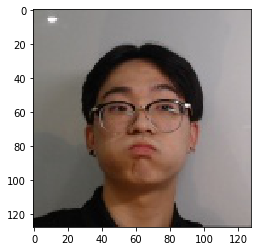

In [12]:
with h5py.File('./celeba_dataset/celeba_aligned_small.h5py', 'r') as file_object:
  for group in file_object:
    print(group)
    pass

celeba_dataset = CelebADataset('./celeba_dataset/celeba_aligned_small.h5py')
celeba_dataset.plot_image(1000)


In [13]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [14]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [15]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View(128*128*3),
            
            nn.Linear(3*128*128, 100),
            nn.LeakyReLU(),
            
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            #print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [ ]:
%%time
# test discriminator can separate real data from random noise
print("start1")
D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    print("start2")
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((128,128,3)), torch.cuda.FloatTensor([0.0]))
    pass

In [16]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 3*128*128),
            
            nn.Sigmoid(),
            View((128,128,3))
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [54]:
D = Discriminator()
G = Generator()
D.to(device)
G.to(device)
epochs = 500
print("start!")

a = time.time()

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator

    for image_data_tensor in celeba_dataset:
        # train discriminator on true
        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

        # train discriminator on false
        # use detach() so gradients in G are not calculated
        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    
        # train generator
        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    #  Util Visualizaing
    output = G.forward(generate_random_seed(100))
    img = output.detach().cpu().numpy()
    cv2.imwrite("v1_vis/face_" + str(epoch+1) + ".jpg", cv2.cvtColor(img*255, cv2.COLOR_BGR2RGB))

b = time.time()
print(b-a)

start!
epoch =  1
epoch =  2
epoch =  3
epoch =  4
epoch =  5
epoch =  6
epoch =  7
epoch =  8
epoch =  9
epoch =  10
epoch =  11
epoch =  12
epoch =  13
epoch =  14
epoch =  15
epoch =  16
epoch =  17
epoch =  18
epoch =  19
epoch =  20
epoch =  21
epoch =  22
epoch =  23
epoch =  24
epoch =  25
epoch =  26


KeyboardInterrupt: 

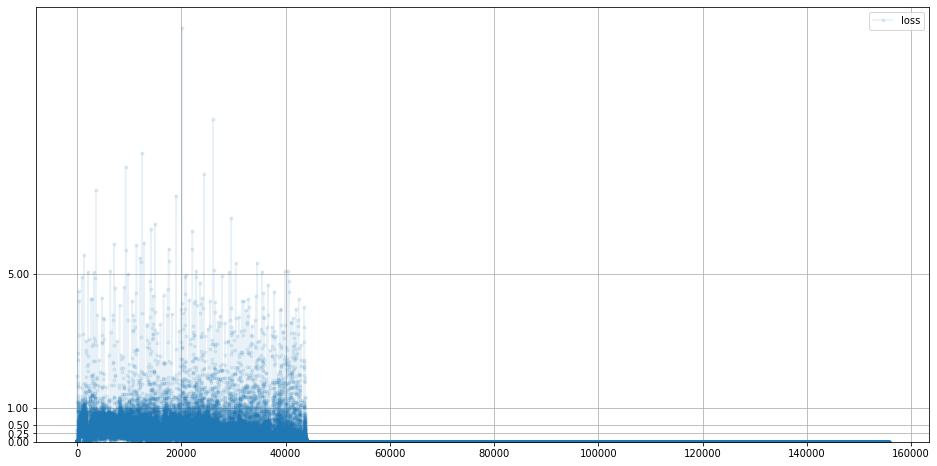

In [55]:
D.plot_progress()

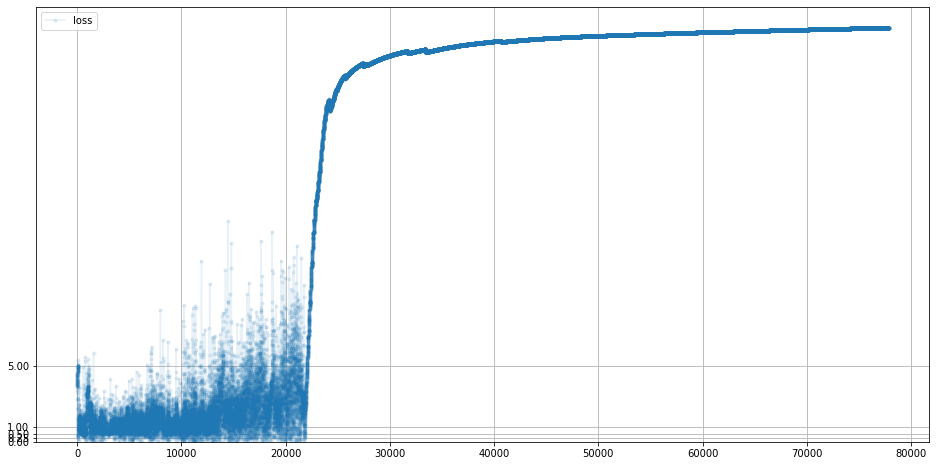

In [56]:
G.plot_progress()

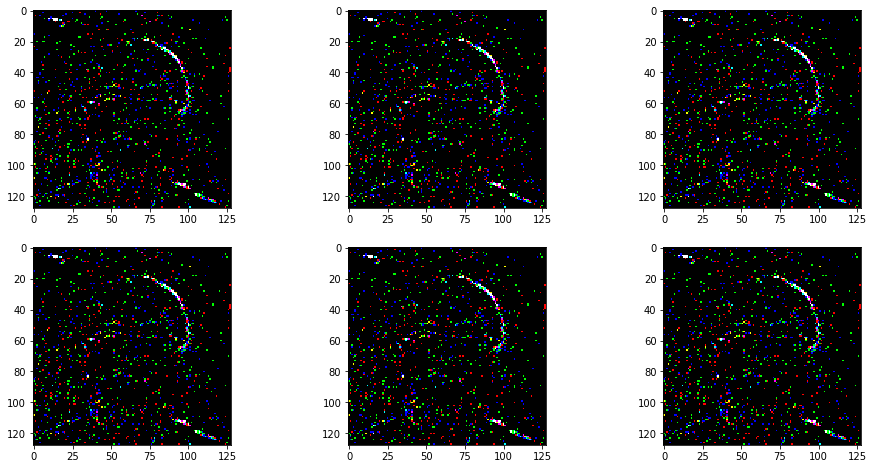

In [60]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [58]:
# current memory allocated to tensors (in Gb)

torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.29454803466796875

In [59]:
# total memory allocated to tensors during program (in Gb)

torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

0.699070930480957